# Testing this example with <a href="https://github.com/fastmachinelearning/hls4ml" class="external">HLS4ML</a>
##### Copyright 2020 The TensorFlow Authors. Notebook modified by <a href="https://github.com/ThGkasios" class="external">ThGkasios</a>
Contents (*clickable links work only in Jupyter*):
- <a href="#Setup">Setup</a>
- <a href="#Import-the-mini-Speech-Commands-Dataset">Import the Dataset</a>
- <a href="#Convert-waveforms-to-spectrograms">Convert waveforms to spectrograms</a>
- <a href="#Build-and-train-the-model">Build and train the model</a>
- <a href="#Processing-the-model-for-hls4ml">Processing the model for hls4ml</a>
- <a href="#HLS4ML-Configuration-&-Compilation">HLS4ML Configuration and Compilation</a>
- <a href="#Resulting-Statistics">Resulting Statistics</a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Source: Tensorflow Example
### Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic <a href="https://en.wikipedia.org/wiki/Speech_recognition" class="external">automatic speech recognition</a> (ASR) model for recognizing eight different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) (<a href="https://arxiv.org/abs/1804.03209" class="external">Warden, 2018</a>), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition <a href="https://ai.googleblog.com/search/label/Speech%20Recognition" class="external">systems</a> are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

In [2]:
import os
import pathlib
import time

import matplotlib.pyplot as plt
import plotting
import numpy as np
import seaborn as sns # Data Visualization
import tensorflow as tf

import hls4ml
import math

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

C:\Users\themi\anaconda3\lib\site-packages\hls4ml\converters\__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


## Import the mini Speech Commands Dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV (Waveform) audio file format</a> of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [3]:
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file('mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True, cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Extract the audio clips into a list called `filenames`, and shuffle it:

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\no\\b06c19b0_nohash_0.wav', shape=(), dtype=string)


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

In [6]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Read the audio files and their labels

In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

- Each WAV file contains time-series data with a set number of samples per second.
- Each sample represents the <a href="https://en.wikipedia.org/wiki/Amplitude" class="external">amplitude</a> of the audio signal at that specific time.
- In a <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16-bit</a> system, like the WAV files in the mini Speech Commands dataset, the amplitude values range from -32,768 to 32,767.
- The <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">sample rate</a> for this dataset is 16kHz.

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, where `channels` is `1` for mono or `2` for stereo. The mini Speech Commands dataset only contains mono recordings. 

In [7]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [8]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [9]:
def get_label(file_path):
  parts = tf.strings.split(input=file_path, sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's plot a few audio waveforms:

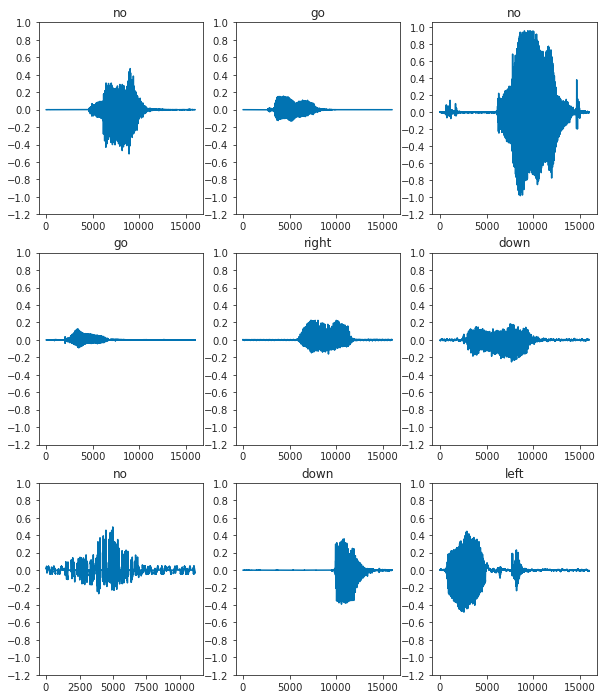

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

# Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">this Coursera video</a> on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [13]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [14]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

C:\Users\themi\AppData\Local\Temp/ipykernel_8360/3600643975.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


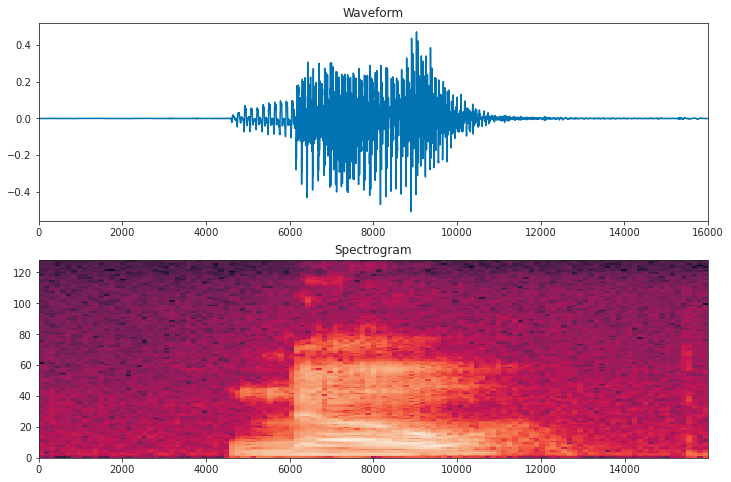

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [18]:
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

C:\Users\themi\AppData\Local\Temp/ipykernel_8360/3600643975.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


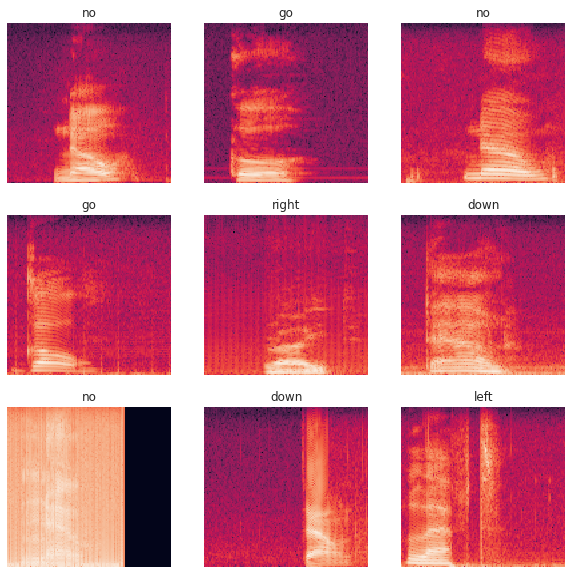

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

# Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [20]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(map_func=get_waveform_and_label,num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)
  return output_ds

In [21]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training:

In [22]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [23]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

## Model Settings

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential" class="external">`tf.keras.Sequential`</a> model will use the following Keras preprocessing layers:
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing" class="external">`tf.keras.layers.Resizing`</a> downsamples the input to enable the model to train faster.
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization" class="external">`tf.keras.layers.Normalization`</a> normalizes each pixel in the image based on its mean and standard deviation.

**As of lately, hls4ml-0.5.x does not support these layers.** For the purposes of this implementation, `Resizing` is omitted, and `Normalization` is replaced by <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization" class="external">`tf.keras.layers.BatchNormalization`</a>, which is supported by hls4ml

In [24]:
input_shape = None
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (124, 129, 1)


The parameters below accommodate different strategies for this design

In [25]:
hw_strategies = {
    # Minimized Latency
    'fast' : {
        'conv2d' : 4,
        'conv2d_1' : 8,
        'dense' : 16,
        'Strategy' : 'Latency',
        'ReuseFactor' : 1
    },
    # Original model values
    'slow' : {
        'conv2d' : 32,
        'conv2d_1' : 64,
        'dense' : 128,
        'Strategy' : 'Resource',
        'ReuseFactor' : 9
    }
}
hw_strat = 'slow'

Creating the `Sequential` model.

In [26]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    #layers.Resizing(32, 32),
    layers.BatchNormalization(),
    layers.Conv2D(hw_strategies[hw_strat]['conv2d'], 3, activation='relu'),
    layers.Conv2D(hw_strategies[hw_strat]['conv2d_1'], 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(hw_strategies[hw_strat]['dense'], activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 124, 129, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 122, 127, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 125, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 62, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 62, 64)        0         
                                                                 
 flatten (Flatten)           (None, 238080)            0

Configure the Keras model with the Adam optimizer and the cross-entropy loss:
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam" class="external">`tf.keras.optimizers.Adam`</a>: "Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments."
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy" class="external">`tf.keras.losses.SparseCategoricalCrossentropy`</a> works with labels being represented as integers, instead of "one-hot" representation.

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=None,verbose=1)

Epoch 1/10
100/100 [==============================] - 664s 7s/step - loss: 1.9856 - accuracy: 0.3237 - val_loss: 2.6266 - val_accuracy: 0.2688
Epoch 2/10
100/100 [==============================] - 625s 6s/step - loss: 1.2659 - accuracy: 0.5792 - val_loss: 1.0447 - val_accuracy: 0.6662
Epoch 3/10
100/100 [==============================] - 627s 6s/step - loss: 0.9052 - accuracy: 0.6961 - val_loss: 0.7956 - val_accuracy: 0.7588
Epoch 4/10
100/100 [==============================] - 626s 6s/step - loss: 0.6793 - accuracy: 0.7680 - val_loss: 0.6529 - val_accuracy: 0.8225
Epoch 5/10
100/100 [==============================] - 626s 6s/step - loss: 0.5426 - accuracy: 0.8142 - val_loss: 0.6682 - val_accuracy: 0.8025
Epoch 6/10
100/100 [==============================] - 626s 6s/step - loss: 0.4378 - accuracy: 0.8534 - val_loss: 0.6497 - val_accuracy: 0.8188
Epoch 7/10
100/100 [==============================] - 660s 7s/step - loss: 0.3725 - accuracy: 0.8717 - val_loss: 0.6335 - val_accuracy: 0.8313

Let's plot the training and validation loss curves to check how your model has improved during training:

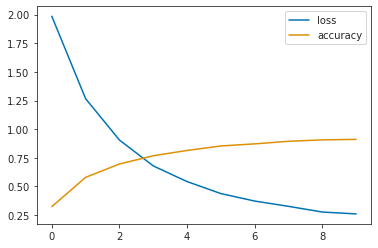

In [28]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], history.epoch, metrics['accuracy'])
plt.legend(['loss', 'accuracy'])
plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [29]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [30]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 82%


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


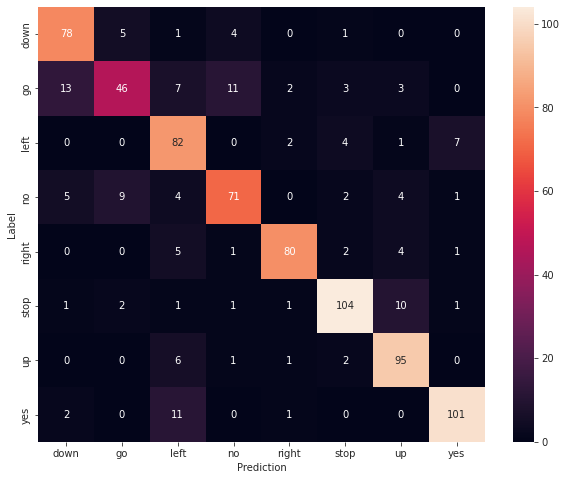

In [31]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

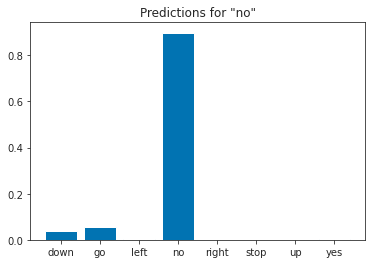

In [32]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

As the output suggests, your model should have recognized the audio command as "no".

# Processing the model for hls4ml

From this model I will attempt to create an HLS model.

### Configuration Parameters

In [33]:
hls_model_base_filename = "simple_hls"
ap_fixed_length = 32
ap_fixed_int_part = 10
xilix_part = None
real_hw = False
if real_hw:
    xilinx_part = "xc7z007sclg225-1" #Avnet MiniZed
else:
    xilinx_part = "xczu7cg-fbvb900-1-i" #Zynq Ultrascale MPSoCs (Max LUT, FF, DSP)
    #xilinx_part = "xc7a200tfbg484-1" #Artix-7 (Max SLICE, BRAM)

### Model JSON file creation
Creating files for model, weights, input data and output predictions
- To re-run this, you have to restart the kernel, as `model.save_weights` doesn't close the file.

In [34]:
with open(hls_model_base_filename+"_model.json", "w") as json_file:
    json_file.write(model.to_json())
    json_file.close()
    
model.save_weights(hls_model_base_filename+"_weights.h5")
with open(hls_model_base_filename+"_weights.h5", "r") as h5_file:
    h5_file.close()

### Test data creation for later experiments

In [35]:
test_samples = ['down/00b01445_nohash_1.wav',
                'go/0a9f9af7_nohash_0.wav',
                'left/00b01445_nohash_0.wav',
                'no/01bb6a2a_nohash_0.wav',
                'right/0ab3b47d_nohash_0.wav',
                'stop/0b40aa8e_nohash_0.wav',
                'up/0ab3b47d_nohash_0.wav',
                'yes/00f0204f_nohash_0.wav']

test_sample_data = []
#append each element
with open(hls_model_base_filename+"_input_data.dat", 'a') as sample_input:
    with open(hls_model_base_filename+"_output_data.dat", 'a') as sample_output:
        for command in test_samples:
            tsd_line = []
            for spectrogram, label in preprocess_dataset([str(data_dir/command)]).batch(1):
                for line1 in spectrogram.numpy():
                    for line2 in line1:
                        for line3 in line2:
                            for num in line3:
                                #sample_input.write(str(num)+' ')
                                sample_input.write('{:.8f}'.format(num)+' ')
                prediction = model(spectrogram)
                #for num in tf.nn.softmax(prediction[0]).numpy():
                for num in prediction[0].numpy():
                    tsd_line.append(num)
                    #sample_output.write(str(num)+' ')
                    sample_output.write('{:.8f}'.format(num)+' ')
            sample_input.write('\n')
            sample_output.write('\n')
            test_sample_data.append(tsd_line)

# HLS4ML Configuration & Compilation

Some notes on the HLSConfig settings

- Generally, the model is tuned for latency, since the bulk of the trainable parameters are on the Convolution and Dense layers.
- The ReuseFactor value isn't the same for every layer, but hls4ml lowers it to the first lower valid value

In [37]:
config_dict = {
    'KerasJson': "{}_model.json".format(hls_model_base_filename),
    'KerasH5': "{}_weights.h5".format(hls_model_base_filename),
    'InputData': "{}_input_data.dat".format(hls_model_base_filename),
    'OutputPredictions': "{}_output_data.dat".format(hls_model_base_filename),
    'OutputDir': 'speechprojectmodel',
    'ProjectName': 'myspeechproject',
    'XilinxPart': xilinx_part,
    'ClockPeriod': 5,
    'IOType': 'io_stream',
    'HLSConfig' : {
        'Model' : {
            'ReuseFactor': 1,
            'Precision': "ap_fixed<{},{}>".format(ap_fixed_length,ap_fixed_int_part), 
            'Strategy': 'Latency'
         },
        'LayerType' : {
            'Conv2D' : {
                'ReuseFactor' :  hw_strategies[hw_strat]['ReuseFactor'],
                'Strategy'    :  hw_strategies[hw_strat]['Strategy'],
            },
            'Dense'  : {
                'ReuseFactor' :  hw_strategies[hw_strat]['ReuseFactor'],
                'Strategy'    :  hw_strategies[hw_strat]['Strategy'],
            },
        },
        'LayerName' : {
            'batch_normalization' : {'Precision' : "ap_fixed<{},{}>".format(27,  6)},
            'conv2d' :              {'Precision' : "ap_fixed<{},{}>".format(32,  8)},
            'conv2d_1' :            {'Precision' : "ap_fixed<{},{}>".format(32,  7)},
            'max_pooling2d' :       {'Precision' : "ap_fixed<{},{}>".format(32,  6)},
            'dense' :               {'Precision' : "ap_fixed<{},{}>".format(32, 10)},
            'dense_1' :             {'Precision' : "ap_fixed<{},{}>".format(28, 10)},
        }
    }
}

# Instantiate the hls model
tic1 = time.time()
hls_model = hls4ml.converters.keras_to_hls(config_dict)
toc1 = time.time()
print('Conversion time', toc1-tic1)
# Compile Model and Run C Simulation
tic2 = time.time()
_ = hls_model.build(csim=True, synth=False, cosim=False)
toc2 = time.time()
print('Build time', toc2-tic2)

Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 124, 129, 1]], output shape: [None, 124, 129, 1]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 124, 129, 1]], output shape: [None, 124, 129, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 124, 129, 1]], output shape: [None, 122, 127, 32]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 122, 127, 32]], output shape: [None, 120, 125, 64]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 120, 125, 64]], output shape: [None, 60, 62, 64]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 60, 62, 64]], output shape: [None, 238080]
Layer name: dense, layer type: Dense, input shapes: [[None, 238080]], output shape: [None, 128]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 128]], output shape: [None, 8]
Creating HLS model
Conversion time 72.63750576972961
Writing HLS pr

If you have more than one test case, you may want to print out the rest of them. You can do that by changing the `CHECKPOINT` definition in the /\[projectname]/[projectname]_test.cpp from the default 5000 to 1. The Vivado HLS log is printed in case there is a segmentation fault.

In [38]:
report_filename = config_dict.get('OutputDir')+'/vivado_hls.log'
if pathlib.Path(report_filename).exists() :
    with open(report_filename, "r") as report_file:
        print(report_file.read())
else :
    print("CSim report file not found")
    print(report_filename)

test_sample_results = []
output_filename = f"{config_dict.get('OutputDir')}/{config_dict.get('ProjectName')}_prj/solution1/csim/build/tb_data/csim_results.log"
if pathlib.Path(output_filename).exists() :
    with open(output_filename, "r") as results_file:
        for line in results_file:
            tsr_line = []
            for str_num in line.split():
                tsr_line.append(float(str_num))
            test_sample_results.append(tsr_line)
        #print(test_sample_results)
else :
    print("CSim results file not found")
    print(output_filename)
    
if not test_sample_results:
    test_sample_results = np.empty(np.shape(test_sample_data))
    test_sample_results[:] = np.nan


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:40:23 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source C:/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running 'C:/Xilinx/Vivado/2019.2/bin/unwrapped/win64.o/vivado_hls.exe'
INFO: [HLS 200-10] For user 'themi' on host 'desktop-bg5uddr' (Windows NT_amd64 version 6.2) on Tue Jun 28 17:09:56 +0300 2022
INFO: [HLS 200-10] In directory 'C:/Users/themi/OneDrive/Desktop/simple_hls/speechprojectmodel'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project 'C:/Users/themi/OneDrive/Desktop/simple_hls/speechprojectmodel/myspeechproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myspeechproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myspeechproject_test.cpp' to the project
INFO: [HLS 200-10] Add

# Resulting Statistics

Below are plotted the outputs for:
- Inference from Keras
- Output from Vivado

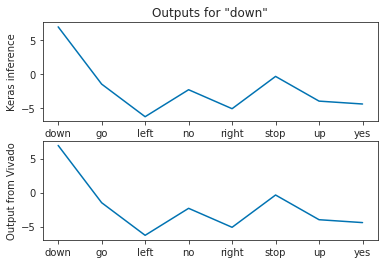

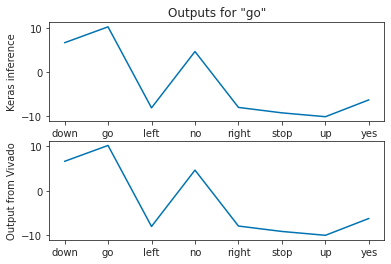

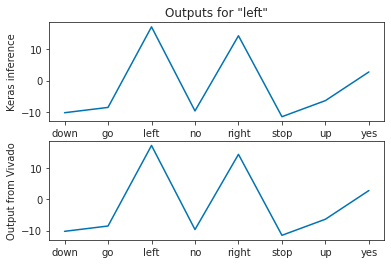

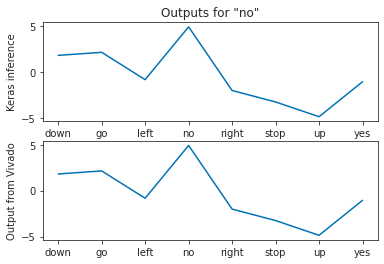

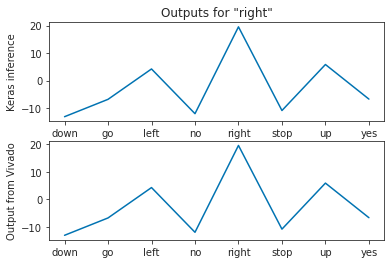

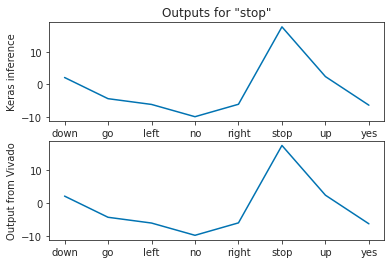

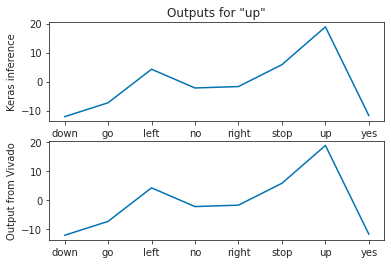

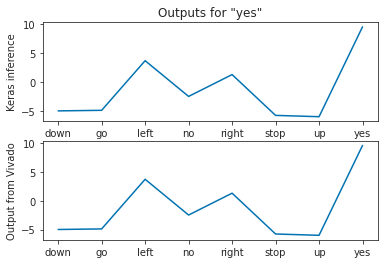

In [39]:
for test_index in range(num_labels):
    plt.figure()
    plt.subplot(211)
    plt.plot(commands, test_sample_data[test_index][:])
    plt.ylabel('Keras inference')
    plt.title(f'Outputs for "{commands[test_index]}"')
    plt.subplot(212)
    plt.plot(commands, test_sample_results[test_index][:])
    plt.ylabel('Output from Vivado')
    plt.show()

At this point, it is evident that for each input the maximum value of the predicted output from the Keras model corresponds to the output of the simulated HLS design, although the HLS Design's output is quantized differently.

Below, I compute some mean deviations based on the difference between sample data and the normalized results.

In [40]:
def print_deviations(original, deviated):
    mean_dev = 0
    mean_dev_correct = 0
    mean_dev_wrong = 0
    mean_dev_by_label = np.zeros(num_labels)
    for i in range(num_labels):
        for j in range(num_labels):
            deviation = abs(original[i][j] - deviated[i][j])
            mean_dev += deviation
            mean_dev_by_label[j] += deviation
            if i == j:
                mean_dev_correct += deviation
            else:
                mean_dev_wrong += deviation

    mean_dev /= math.pow(num_labels,2)
    mean_dev_correct /= num_labels
    mean_dev_wrong /= (math.pow(num_labels,2) - num_labels)
    for i in range(num_labels):
        mean_dev_by_label[i] /= num_labels

    print('Average deviation between all results:', mean_dev)
    print('Average deviation between correct labels:', mean_dev_correct)
    print('Average deviation between wrong labels:', mean_dev_wrong)
    print('Average deviation per label:')
    for i in range(num_labels):
        print(f' -{commands[i]}\t: {str(mean_dev_by_label[i])}')
    return mean_dev

print('=== Statistics between Keras and Vivado output ===')
_ = print_deviations(test_sample_data, test_sample_results)

=== Statistics between Keras and Vivado output ===
Average deviation between all results: 0.0033372134738862587
Average deviation between correct labels: 0.007308292694091945
Average deviation between wrong labels: 0.0027699164424283035
Average deviation per label:
 -down	: 0.0033598059463502694
 -go	: 0.002633739705085597
 -left	: 0.0030109974799159694
 -no	: 0.003076985359191653
 -right	: 0.0032249473237992987
 -stop	: 0.0039755513966084205
 -up	: 0.003534325456619025
 -yes	: 0.0038813551235198362


### Experimenting with various precision settings
This helper function contains all neccesary steps to run an experiment on precision.

In [ ]:
def model_decimal_point_experiment(layer_name, length, position):
    #Keeping config_dict intact after an experiment with saving and rewriting
    temp_precision = config_dict['HLSConfig']['LayerName'][layer_name]['Precision']
    temp_outputdir = config_dict['OutputDir']
    assert layer_name is not None
    precision_str = "ap_fixed<{},{}>".format(length, position)
    print("\n=== Running experiment for",precision_str,"precision ===")
    config_dict['HLSConfig']['LayerName'][layer_name]['Precision'] = precision_str
    config_dict['OutputDir'] = "spmpe_{}_{}_{}".format(layer_name, length, position)
    # Instantiate the hls model
    test_hls_model = hls4ml.converters.keras_to_hls(config_dict)
    # Compile Model and Run C Simulation
    test_hls_model.build(csim=True, synth=False, cosim=False)
    #Run Experiment
    test_experiment_sample_results = []
    output_filename = f"{config_dict.get('OutputDir')}/{config_dict.get('ProjectName')}_prj/solution1/csim/build/tb_data/csim_results.log"
    mean_dev = 0
    if pathlib.Path(output_filename).exists() :
        with open(output_filename, "r") as results_file:
            for line in results_file:
                tsr_line = []
                for str_num in line.split():
                    tsr_line.append(float(str_num))
                test_experiment_sample_results.append(tsr_line)
        mean_dev = print_deviations(test_sample_data, test_experiment_sample_results)
    else :
        mean_dev = np.nan
    #Delete experiment products for next run
    os.system("rmdir /s {}".format(config_dict.get('OutputDir')))
    os.system("del {}.tar.gz".format(config_dict.get('OutputDir')))
    #Restore config_dict to previous
    config_dict['HLSConfig']['LayerName'][layer_name]['Precision'] = temp_precision
    config_dict['OutputDir'] = temp_outputdir
    return mean_dev

Expriment execution

In [ ]:
experiment_results = np.empty(32)
experiment_results[:] = np.nan
tested_layer_name = 'dense'
do_the_experiment = False
if do_the_experiment:
    for i in range (11,32):
        experiment_results[i] = model_decimal_point_experiment(tested_layer_name, i, 10)
        plt.figure()
        plt.semilogy(experiment_results)
        plt.title('Keras and Vivado output precision experiment')
        plt.xlabel('Number Size (Decimal Point is fixed)')
        plt.ylabel('Mean Deviation between final outputs')
        plt.grid()
        plt.show()
        print('Minimum Point:',np.nanargmin(experiment_results))
        print('Minimum Point:',np.nanmin(experiment_results))

The result of manipulating the decimal point can be seen here.
- The sheer drop in the mean deviation marks the point where the integer part in the HLS model is large enough to accommodate the needs of the model.
  - This is not always accurate, as other samples might require the accumulation of values with even larger integer parts within the model as they are processed.